In [2]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
from ipypb import track
import warnings
from collections.abc import Iterable

### Selecting nearest pixels to sampling points

In [2]:
def crop_xpixels_point(point,raster,polygon,poly_buffer,n_pixels,outpath):
    '''
    Requires 
    - point: a Geopandas object
    - raster: a raster object as read by rasterio
    - poly_buffer: a buffer to be applied to polygon in units of CRS
    - n_pixels: number of required pixels to be returned
    - outpath: name and path for saving raster
    '''
    
    #~~~~ crop raster to internal water body ~~~~#
    
    with rio.open(raster) as src:
    
        #assert point.crs==src.crs, f'CRS of {polygon} and {src} must be the same'
        
        geoms = polygon.buffer(poly_buffer).geometry
        
        try:
            ## Put any single geoms into a list
            if not isinstance(geoms, Iterable):
                geoms = [geoms]

            ## Crop raster in water body interior

            raster_crop, raster_crop_meta = es.crop_image(src, geoms)

            raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                                 'height': raster_crop.shape[1],
                                 'width': raster_crop.shape[2],
                                 'nodata': raster_crop.min()})

            with rio.open(outpath, 'w', **raster_crop_meta) as file:
                file.write(raster_crop[0], 1)
                   
            proceed = True
            
            src.close()
                
        except:
            proceed = False 
            src.close()
    
    src.close()
    
    if proceed == False:
        print(f'Polygon and raster do not intersect for site: {sid}')
      
    #~~~~ for loop to define buffer distance based on required pixels ~~~~#
    
    if proceed == True:
    
        with rio.open(outpath) as src:

            #assert point.crs==src.crs, f'CRS of {point} and {src} must be the same'

            pixel_count = 0

            for i in range(2,500,1):

                if pixel_count<n_pixels:

                    pts_buf_geom = point.buffer(i).geometry

                    ## Put any single geoms into a list
                    if not isinstance(pts_buf_geom, Iterable):
                        pts_buf_geom = [pts_buf_geom]

                    try: 
                        ## Crop raster to point buffer
                        raster_crop, raster_crop_meta = es.crop_image(src, pts_buf_geom)

                        raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                                                 'height': raster_crop.shape[1],
                                                 'width': raster_crop.shape[2],
                                                 'nodata': raster_crop.min()})

                        pixel_count = len(raster_crop[raster_crop>0])

                    except:
                        pixel_count = 0

                    ## distance for required pixel number
                    buf_dis = i-1

            with rio.open(outpath, 'w', **raster_crop_meta) as file:
                file.write(raster_crop[0], 1)

            pixels = rio.open(outpath)

            src.close()

    else:
            
        pixels = np.array([-999,-999,-999,-999,-999,-999,-999,-999,-999])
        pixel_count = ['failed']
        buf_dis = ['failed']          
            
    return pixels,pixel_count,buf_dis
    


In [9]:
#~~~~ EDIT COPY~~~~~

def crop_xpixels_point(point,raster,polygon,poly_buffer,n_pixels,outpath):
    '''
    Requires 
    - point: a Geopandas object
    - raster: a raster object as read by rasterio
    - poly_buffer: a buffer to be applied to polygon in units of CRS
    - n_pixels: number of required pixels to be returned
    - outpath: name and path for saving raster
    '''
    
    #~~~~ crop raster to internal water body ~~~~#
    
    with rio.open(raster) as src:
    
        #assert point.crs==src.crs, f'CRS of {polygon} and {src} must be the same'
        
        geoms = polygon.buffer(poly_buffer).geometry
        
        #try:
        ## Put any single geoms into a list
        if not isinstance(geoms, Iterable):
            geoms = [geoms]

        ## Crop raster in water body interior

        raster_crop, raster_crop_meta = es.crop_image(src, geoms)

        raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()})

        with rio.open(outpath, 'w', **raster_crop_meta) as file:
            file.write(raster_crop[0], 1)

            proceed = True

            src.close()

#     except:
#         proceed = False 
        src.close()
    
    src.close()
    
    if proceed == False:
        print(f'Polygon and raster do not intersect for site: {sid}')
      
    #~~~~ for loop to define buffer distance based on required pixels ~~~~#
    
    if proceed == True:
    
        with rio.open(outpath) as src:

            #assert point.crs==src.crs, f'CRS of {point} and {src} must be the same'

            pixel_count = 0

            for i in range(2,500,1):

                if pixel_count<n_pixels:

                    pts_buf_geom = point.buffer(i).geometry

                    ## Put any single geoms into a list
                    if not isinstance(pts_buf_geom, Iterable):
                        pts_buf_geom = [pts_buf_geom]

                    try: 
                        ## Crop raster to point buffer
                        raster_crop, raster_crop_meta = es.crop_image(src, pts_buf_geom)

                        raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                                                 'height': raster_crop.shape[1],
                                                 'width': raster_crop.shape[2],
                                                 'nodata': raster_crop.min()})

                        pixel_count = len(raster_crop[raster_crop>0])

                    except:
                        pixel_count = 0

                    ## distance for required pixel number
                    buf_dis = i-1

            with rio.open(outpath, 'w', **raster_crop_meta) as file:
                file.write(raster_crop[0], 1)

            pixels = rio.open(outpath)

            src.close()

    else:
            
        pixels = np.array([-999,-999,-999,-999,-999,-999,-999,-999,-999])
        pixel_count = ['failed']
        buf_dis = ['failed']          
            
    return pixels,pixel_count,buf_dis
    


### Read in site data

In [3]:
os.chdir("C:/Users/User/Documents/Work/SDGs and AI/6.3.2")

sites = pd.read_pickle("sites2.p")
sites = sites.reset_index().set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')
sites = sites.drop(columns=['monitoringSiteIdentifier','wbid','thematicId'])

#### Sample site

13


13

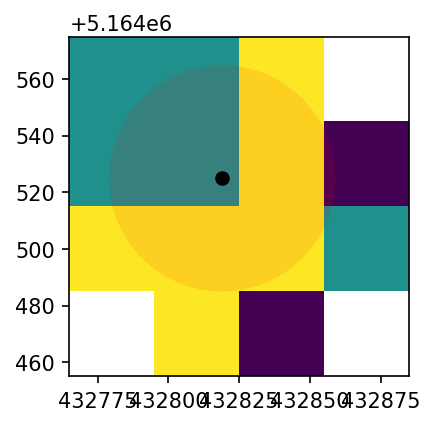

In [260]:
path = 'C:/Users/User/Documents/test.tif'

src,count,buf_dis = crop_xpixels_point(pts,sid_file[1],poly,-100,13,path)
 
fig, ax = plt.subplots(dpi=150, figsize =(5, 3))

#poly.plot(ax=ax)
pts.buffer(buf_dis).plot(ax=ax,color='r',alpha=0.1)
show(src,ax=ax)
pts.plot(ax=ax,color='k')


print(count)
data = src.read(1)
len(data[data>0])

### Batch processing

In [4]:
pl = sites[(sites['l8_scene_id'].notna())|(sites['l7_scene_id'].notna())]
pl = pl[pl.geometry_poly.notna()]

In [7]:
dl_files = os.listdir()

## list of files already processed
pixel_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/")


sid_files_tp = [ i for i in dl_files if i not in pixel_files ]

In [9]:
len(sid_files_tp),len(dl_files),len(pixel_files)

(16814, 37834, 21020)

In [12]:
os.chdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data V2")

## list of files to process
dl_files = os.listdir()

## list of files already processed
pixel_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/")

#for sid in track(pl.index.get_level_values(0).unique()):
sid = 'ATSE20201000'
sid_files = [ i for i in dl_files if sid in i ]

sid_files_tp = [ i for i in sid_files if i not in pixel_files ]

if len(sid_files_tp)>0:

    ## get CRS of raster
    with rio.open(sid_files_tp[0]) as src:            

        ras_crs = src.crs

    src.close()

    ## retrieve monitoring location as point
    pt = pl.loc[sid,:].set_geometry('geometry_ll')             

    ## change crs of pt
    original_crs = pl.crs
    pt = pt.to_crs(ras_crs)

    ## change crs of poly
    poly = pt.set_geometry('geometry_poly')
    poly.crs = original_crs
    poly = poly.to_crs(ras_crs)        

    for ras in sid_files_tp:

        path = "C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/"+ras

        try:

            pixels,pixel_count,buf_dis = crop_xpixels_point(pt,ras,poly,-100,9,path)
            src.close()

        except:
            print(f'pixel extraction failed: {ras}')



### Reading pixels values

In [149]:
pixel_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/")

for file in track(pixel_files):
    
    with rio.open(file) as src:
    
        data = src.read(1)
        data = data[data>0][0:9]

        if 'T1' in file:
            band = src.name.split('T1_')[1].replace('.tif','')
            eid = src.name.split('__')[1][0:40]
        else:
            band = src.name.split('T2_')[1].replace('.tif','')
            eid = src.name.split('__')[1][0:40]


        df1 = pd.DataFrame(data.flatten()).transpose()
        df2 = pd.DataFrame([sid,eid,band,buf_dis]).transpose().rename(columns={0:'sid',1:'eid',2:'band',3:'buf_dis'})
        df = pd.concat([df2,df1],axis=1)

        li.append(df)


final_df2 = pd.concat(li, axis=0, ignore_index=True)

,0,1,2,0,1,2,3,4,5,6,7,8
0,ATSE20101000,LE07_L1TP_191028_20100524_20161214_01_T1,B1_sre,0.057366,0.057366,0.052284,0.057366,0.05906,0.057366,0.055672,0.057366,0.053978
